# Theoretical values of energies

In [6]:
# %load ../../preamb.py
import numpy as np
import uncertainties as uc
import uncertainties.unumpy as un
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter as sav
from scipy.special import erfc
from scipy.integrate import quad
import sys
import re

npy_dir = "./npy/"


In [22]:
# %load "../../style.py"
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import colorConverter
from matplotlib import rcParams
import seaborn as sns
from scipy.optimize import curve_fit

sns.set(style='ticks', palette='Set2') 
sns.despine()

# These are the colors. Notice how this is programmed:
# You initialize your colors by 
# colorset = palette()
# then you can cycle through the colors:
# color = next(colorset)
# if you want your set to be reset, just create
# a new palette() instance! This way the colors do not interfere.

color_names = ['windows blue', "pale red", "faded green", "amber", 
          'dark green', 'dark fuchsia', 'browny orange', 
          'puke green', 'dark royal blue', 'dusty purple', 'red orange']
colors = sns.xkcd_palette(color_names)
palette = lambda: itertools.cycle(sns.xkcd_palette(color_names) )

fontsize_labels = 26    # size used in latex document
rcParams['text.latex.preamble'] = [r'\usepackage[cmbright]{sfmath}']
rcParams['font.family']= 'sans-serif'
rcParams['font.sans-serif']= 'cmbright'
rcParams['font.weight'] = "light"

rcParams['text.usetex'] = True

rcParams['figure.autolayout'] = True
rcParams['font.size'] = fontsize_labels
rcParams['axes.labelsize'] = fontsize_labels
rcParams['xtick.labelsize'] = fontsize_labels
rcParams['ytick.labelsize'] = fontsize_labels
rcParams['legend.fontsize'] = fontsize_labels
rcParams['legend.markerscale'] = 4
rcParams['axes.titlesize'] = fontsize_labels
rcParams['text.color'] = "0.3"
rcParams['xtick.color'] = "0.3"
rcParams['ytick.color'] = "0.3"
rcParams['axes.labelcolor'] = "0.3"
rcParams['axes.edgecolor'] = "0.8"
rcParams['lines.linewidth'] = 4

xfactor = 2
rcParams['figure.figsize'] = (xfactor*6.2, xfactor*3.83)  

save_fig = True
if not save_fig:
        rcParams['figure.figsize'] = (13, 8) 
fig_dir = "./figures/"  # directory of figures

def fixticks(ax):    
    for t in ax.xaxis.get_ticklines(): t.set_color('0.8')
    for t in ax.yaxis.get_ticklines(): t.set_color('0.8')


In [15]:
# %load "../../preamb.py"
import numpy as np
import uncertainties as uc
import uncertainties.unumpy as un
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter as sav
from scipy.special import erfc
from scipy.integrate import quad
import sys

npy_dir = "./data_npy/"


## Functions

In [16]:
from scipy.constants import physical_constants as pc

def E_red(E_gamma):
    # Energy in units of electron mass energy equivalent
    m_e = pc["electron mass energy equivalent in MeV"][0] * 10**3 # in keV
    return(E_gamma / m_e)

/usr/lib/python3/dist-packages/matplotlib/figure.py:1596: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


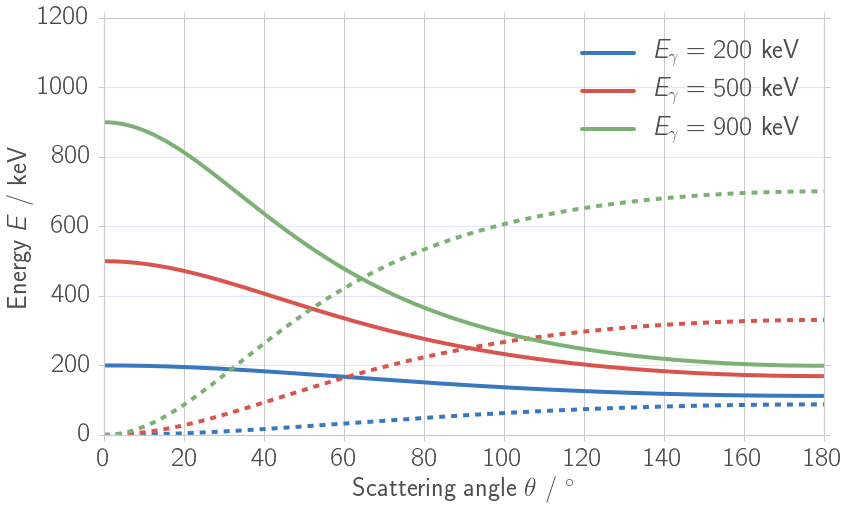

In [23]:
def E_photon(E_gamma, theta_deg):
    # Energy of scattered photon in keV
    theta = theta_deg * np.pi / 180
    b = E_red(E_gamma) * (1 - np.cos(theta))
    return E_gamma / (1 + b)

def E_electron(E_gamma, theta_deg):
    # Energy of scattered electron in keV
    theta = theta_deg * np.pi / 180
    b = E_red(E_gamma) * (1 - np.cos(theta))
    return E_gamma * b / (1 + b)

theta = np.linspace(0, 180, 200)
E_gammas = [200, 500, 900] # keV

# Plotting
fig1, ax1 = plt.subplots(1, 1)
fixticks(ax1)
if not save_fig:
    fig1.suptitle("Distribution of energy of scattered photons and electrons")
for i, E_gamma in enumerate(E_gammas):
    ax1.plot(theta, E_photon(E_gamma, theta), '-', c=colors[i], 
             label='$E_\gamma = %i$ keV'%E_gamma)
    ax1.plot(theta, E_electron(E_gamma, theta), '--', c=colors[i])
ax1.set_xlabel("Scattering angle $\\theta$ / $^\circ$")
ax1.set_ylabel("Energy $E$ / keV")
ax1.set_xlim(0, 180)
ax1.set_ylim(0, 1200)
ax1.legend(loc=1,markerscale = 2)
ax1.grid(True)

ax1.yaxis.grid(True,'minor',linewidth=0.5,color = "blue", alpha = 0.1)
ax1.yaxis.grid(True,'major',linewidth=1.2, color = "blue", alpha = 0.1)
ax1.xaxis.grid(True)

if save_fig:
    file_name = "theory_conservation"
    fig1.savefig(fig_dir + file_name + ".pdf")
    fig1.savefig(fig_dir + file_name + ".png")


/usr/lib/python3/dist-packages/matplotlib/figure.py:1596: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


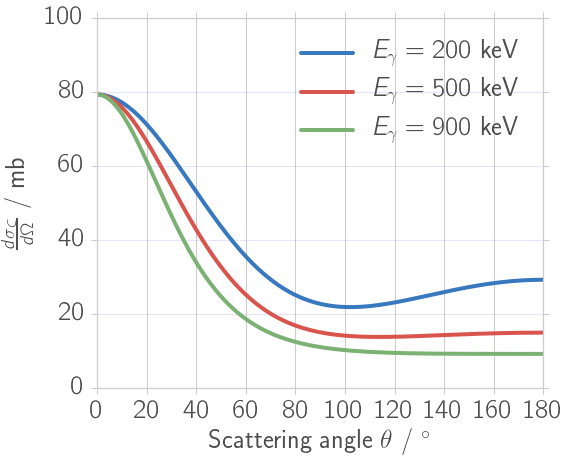

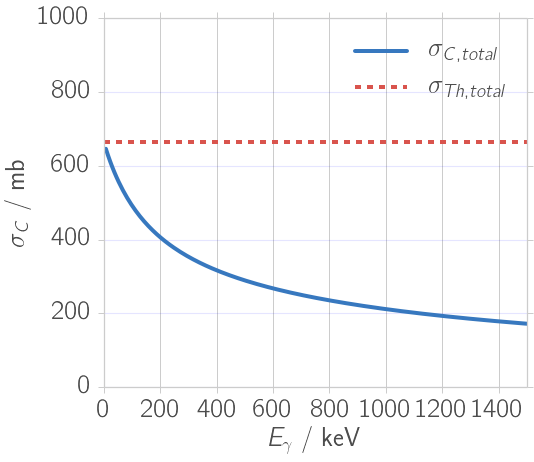

In [24]:
def dsdo(E_gamma, theta_deg):
    #Klein-Nishina differential cross section
    theta = theta_deg * np.pi / 180
    alpha = pc["fine-structure constant"][0] # fine struc. const.
    lamb_C = pc["Compton wavelength"][0] # Compton wavelength in m
    rho = 1 + E_red(E_gamma) * (1 - np.cos(theta)) # = E_gamma / E_photon
    A = (alpha * lamb_C / np.pi)**2 / 8 * 10**31 # in mb
    return A / rho**2 * (rho + 1 / rho - np.sin(theta)**2)

def total_cs(E_gamma):
    alpha = pc["fine-structure constant"][0] # fine struc. const.
    lamb_C = pc["Compton wavelength"][0] # Compton wavelength in m
    a = E_red(E_gamma)
    A = (alpha * lamb_C / a)**2 / (2 * np.pi) * 10**31 # in mb
    return A * ((2 + a*(1 + a) * (8 + a))/(1 + 2*a)**2 + ((a - 1)**2 - 3)/(2*a) * np.log(1 + 2*a))

theta = np.linspace(0, 180, 200)
E_gammas = [200, 500, 900] # keV

# Plotting
fig2, ax2 = plt.subplots(1,1, figsize=(8.5, 7))
fixticks(ax2)
if not save_fig:
    fig2.suptitle("Differential cross section of Compton scattering (Klein Nishina formula)")
for i, E_gamma in enumerate(E_gammas):
    ax2.plot(theta, dsdo(E_gamma, theta), '-', c=colors[i], 
             label='$E_\gamma = %i$ keV'%E_gamma)
ax2.set_xlabel("Scattering angle $\\theta$ / $^\circ$")
ax2.set_ylabel("$\\frac{\\text{d} \sigma_\\text{C}}{\\text{d} \Omega}$ / mb")
ax2.set_xlim(0, 180)
ax2.set_ylim(0, 100)
ax2.legend(loc='best',markerscale = 2)
ax2.grid(True)
ax2.yaxis.grid(True,'minor',linewidth=0.5,color = "blue", alpha = 0.1)
ax2.yaxis.grid(True,'major',linewidth=1.2, color = "blue", alpha = 0.1)
ax2.xaxis.grid(True)

E_gamma_all = np.linspace(0, 1.5e3, 200)
cs_thomson = 665.2
fig3, ax3 = plt.subplots(1,1, figsize=(8, 7))
fixticks(ax3)
if not save_fig:
    fig3.suptitle("Total cross section of Compton scattering")
ax3.plot(E_gamma_all, total_cs(E_gamma_all), '-', c=colors[0], label='\sigma_\\text{C, total}')
ax3.plot([0, 1500], [cs_thomson]*2, '--', c=colors[1], label='\sigma_\\text{Th, total}')
ax3.set_xlabel("$E_\gamma$ / keV")
ax3.set_ylabel("$\sigma_\\text{C}$ / mb")
ax3.set_xlim(0, 1.5e3)
ax3.set_ylim(0, 1000)
ax3.legend(loc='best',markerscale = 2)
ax3.grid(True)
ax3.yaxis.grid(True,'minor',linewidth=0.5,color = "blue", alpha = 0.1)
ax3.yaxis.grid(True,'major',linewidth=1.2, color = "blue", alpha = 0.1)
ax3.xaxis.grid(True)

if save_fig:
    file_name = "theory_diff_cs"
    fig2.savefig(fig_dir + file_name + ".pdf")
    fig2.savefig(fig_dir + file_name + ".png")
    file_name = "theory_total_cs"
    fig3.savefig(fig_dir + file_name + ".pdf")
    fig3.savefig(fig_dir + file_name + ".png")


/usr/lib/python3/dist-packages/matplotlib/figure.py:1596: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


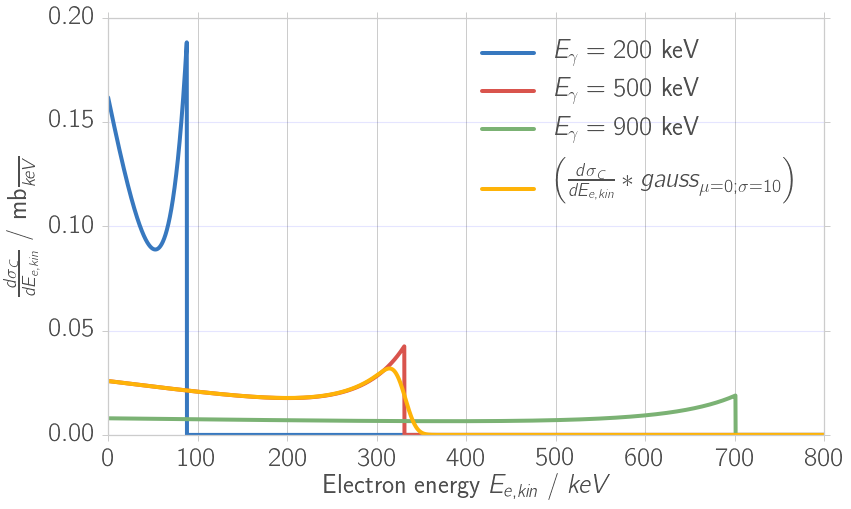

In [25]:
def E_C(E_gamma):
    m_e = pc["electron mass energy equivalent in MeV"][0] * 10**3 # in keV
    # Compton edge in keV
    return E_gamma / (1 + m_e / (2 * E_gamma))
    
def dsdE(E_e, E_gamma=662):
    # Diff cross section over electron energy in keV
    m_e = pc["electron mass energy equivalent in MeV"][0] * 10**3 # in keV
    alpha = pc["fine-structure constant"][0] # fine struc. const.
    lamb_C = pc["Compton wavelength"][0] # Compton wavelength in m
    a = E_red(E_gamma)
    b = E_e / m_e
    A = (alpha * lamb_C / a)**2 / (16 * np.pi**3 * m_e) * 10**31 # in mbarn / keV
    dsde = A * (b**2 / (a * (a - b))**2 + ((b - 1)**2 - 1) / (a * (a - b)) + 2) * \
        (E_e <= E_C(E_gamma)) # in mbarn / keV
    #dsdE[np.isnan(dsdE)] = 0
    return(dsde)

def gauss(x, *p):
    mu, sigma = p
    return  1 / (np.sqrt(2 * np.pi) * sigma) * np.exp(-(x - mu)**2 / (2. * sigma**2))


E_gammas = np.array([200, 500, 900]) # keV
E_Cs = E_C(E_gammas)
Emax = max(E_Cs) * 1.5
n_x = 10001
E_e = np.linspace(-Emax, Emax, n_x)

# convolve
mu, sigma = 0, 10
smeared = np.convolve(dsdE(E_e, E_gammas[1]), gauss(E_e, mu, sigma), 'same') * 2 * Emax / n_x
smeared[np.isnan(smeared)] = 0

# Plotting
fig1, ax1 = plt.subplots(1, 1)
fixticks(ax1)
if not save_fig:
    fig1.suptitle("Distribution of energy of scattered photons and electrons")
for i, E_gamma in enumerate(E_gammas):
    ax1.plot(E_e, dsdE(E_e, E_gamma), '-', c=colors[i], 
             label='$E_\gamma = %i$ keV'%E_gamma)
ax1.plot(E_e, smeared, '-', c=colors[i+1], \
         label=r'$\left(\frac{\text{d} \sigma_\text{C}}{\text{d} E_{e, \text{kin}}} * \
         \text{gauss}_{\mu=0; \sigma = 10} \right)$')
ax1.set_xlabel("Electron energy $E_{e, \\text{kin}}$  / $keV$")
ax1.set_ylabel("$\\frac{\\text{d} \sigma_\\text{C}}{\\text{d} E_{e, \\text{kin}}}$ / \\frac{mb}{keV}")
ax1.set_xlim(0, 800)
ax1.set_ylim(0, 0.2)
ax1.legend(loc=1,markerscale = 2)
ax1.grid(True)
ax1.yaxis.grid(True,'minor',linewidth=0.5,color = "blue", alpha = 0.1)
ax1.yaxis.grid(True,'major',linewidth=1.2, color = "blue", alpha = 0.1)
ax1.xaxis.grid(True)

if save_fig:
    file_name = "theory_dsde"
    fig1.savefig(fig_dir + file_name + ".pdf")
    fig1.savefig(fig_dir + file_name + ".png")